In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, StratifiedKFold, validation_curve, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

RANDOM_STATE = 42


In [2]:
data = load_wine()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

X.shape, y.shape, X_train.shape, X_test.shape


((178, 13), (178,), (142, 13), (36, 13))

In [3]:
pipe_l1 = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(penalty="l1", solver="saga",
                               multi_class="multinomial", max_iter=5000,
                               random_state=RANDOM_STATE))
])

pipe_l2 = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(penalty="l2", solver="saga",
                               multi_class="multinomial", max_iter=5000,
                               random_state=RANDOM_STATE))
])

pipe_l1.fit(X_train, y_train)
pipe_l2.fit(X_train, y_train)

print("== L1 ==")
print(classification_report(y_test, pipe_l1.predict(X_test), target_names=data.target_names))

print("== L2 ==")
print(classification_report(y_test, pipe_l2.predict(X_test), target_names=data.target_names))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


== L1 ==
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        12
     class_1       0.93      1.00      0.97        14
     class_2       1.00      0.90      0.95        10

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36

== L2 ==
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        12
     class_1       0.93      1.00      0.97        14
     class_2       1.00      0.90      0.95        10

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


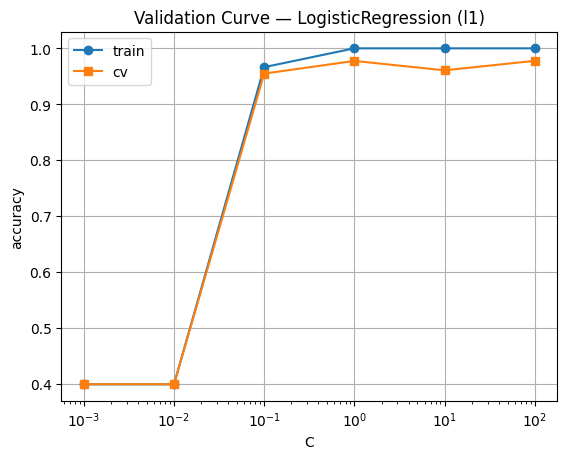

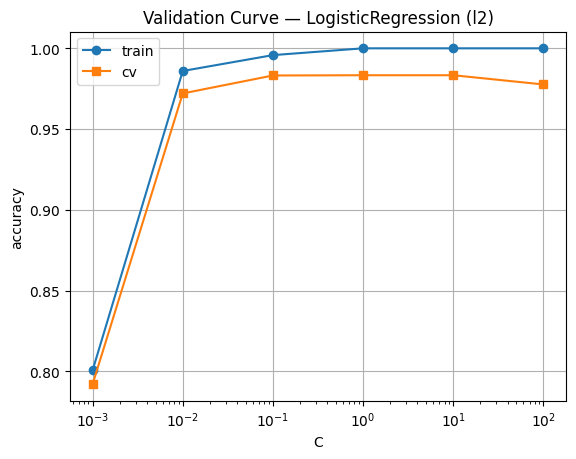

In [4]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def plot_validation_curve(penalty):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(penalty=penalty, solver="saga",
                                   multi_class="multinomial", max_iter=5000,
                                   random_state=RANDOM_STATE))
    ])
    param_range = np.logspace(-3, 2, 6)  # 1e-3 ... 1e2
    train_scores, test_scores = validation_curve(
        pipe, X, y,
        param_name="clf__C", param_range=param_range,
        cv=cv, scoring="accuracy", n_jobs=-1
    )
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    plt.figure()
    plt.semilogx(param_range, train_mean, marker='o', label="train")
    plt.semilogx(param_range, test_mean, marker='s', label="cv")
    plt.xlabel("C")
    plt.ylabel("accuracy")
    plt.title(f"Validation Curve — LogisticRegression ({penalty})")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_validation_curve("l1")
plot_validation_curve("l2")


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **la

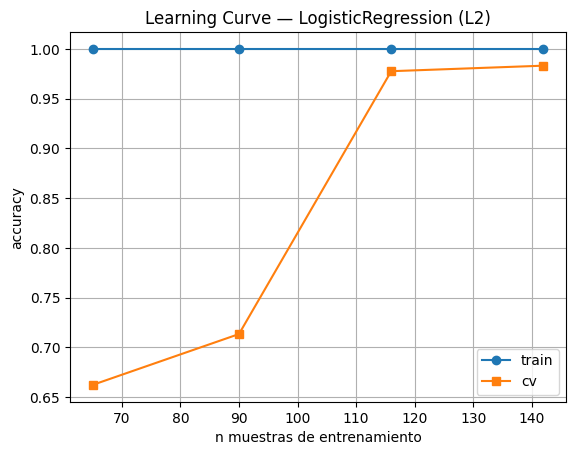

In [5]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(penalty="l2", solver="saga",
                               multi_class="multinomial", max_iter=5000,
                               random_state=RANDOM_STATE, C=1.0))
])

train_sizes, train_scores, test_scores = learning_curve(
    pipe, X, y, cv=5, scoring="accuracy", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 6), random_state=RANDOM_STATE
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, marker='o', label="train")
plt.plot(train_sizes, test_mean, marker='s', label="cv")
plt.xlabel("n muestras de entrenamiento")
plt.ylabel("accuracy")
plt.title("Learning Curve — LogisticRegression (L2)")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
pipe_l1_Csmall = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(penalty="l1", solver="saga",
                               multi_class="multinomial", max_iter=5000,
                               random_state=RANDOM_STATE, C=0.3))
])
pipe_l1_Csmall.fit(X_train, y_train)

clf = pipe_l1_Csmall.named_steps["clf"]
coefs = clf.coef_
sparsity = (coefs == 0.0).mean()
print("Porcentaje de ceros en coeficientes (promedio):", round(sparsity * 100, 2), "%")

feature_names = load_wine().feature_names
for k in range(coefs.shape[0]):
    row = coefs[k]
    top_idx = np.argsort(np.abs(row))[::-1][:5]
    print("Clase", k, "- Top 5 |coef|:", [feature_names[i] for i in top_idx])


Porcentaje de ceros en coeficientes (promedio): 66.67 %
Clase 0 - Top 5 |coef|: ['proline', 'alcalinity_of_ash', 'od280/od315_of_diluted_wines', 'flavanoids', 'hue']
Clase 1 - Top 5 |coef|: ['color_intensity', 'alcohol', 'ash', 'proline', 'malic_acid']
Clase 2 - Top 5 |coef|: ['flavanoids', 'hue', 'od280/od315_of_diluted_wines', 'color_intensity', 'proline']


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
